In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow
import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from scipy import stats

2023-04-21 22:33:24.728902: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
asymp = np.load('/raid/mpsych/CACTAS/DATA/ESUS/asymp_cropped_no_norm.npy')
symp = np.load('/raid/mpsych/CACTAS/DATA/ESUS/symp_cropped_no_norm.npy')

In [4]:
labels = np.array([0]*len(asymp) + [1]*len(symp))
images = np.concatenate((asymp, symp))

In [5]:
asymp_test = np.load('/raid/mpsych/CACTAS/DATA/ESUS/asymp_cropped.npy')
symp_test = np.load('/raid/mpsych/CACTAS/DATA/ESUS/symp_cropped.npy')

In [6]:
labels_test = np.array([0]*len(asymp_test) + [1]*len(symp_test))
images_test = np.concatenate((asymp_test, symp_test))

In [7]:
X, y = shuffle(images_test, labels_test, random_state=0)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

In [9]:
train_data_gen = ImageDataGenerator(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    )

In [10]:
test_data_gen = ImageDataGenerator()

In [11]:
train = train_data_gen.flow(X_train, y_train)

In [12]:
test = test_data_gen.flow(X_test, y_test)

In [13]:
model = tensorflow.keras.Sequential()

model.add(layers.Conv2D(filters=20, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=50, kernel_size=(5, 5), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(units=256, activation='relu'))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(units=1, activation = 'softmax'))  

2023-04-21 22:33:26.618659: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-21 22:33:26.833240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-21 22:33:26.835866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-21 22:33:26.835886: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-21 22:33:26.839796: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-21 

In [14]:
sgd = tensorflow.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [15]:
model.compile(loss=tensorflow.keras.losses.binary_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

In [16]:
batch_size = 32

In [ ]:
model.fit_generator(train,steps_per_epoch=len(X_train) // batch_size, verbose=True, epochs=10)

In [17]:
train_f1 = []
test_f1 = []
for i in range(10):
    X, y = shuffle(images, labels, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=0)
    rf = RandomForestClassifier(n_estimators=100)
    
    X_train_raveled = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
    X_val_raveled = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])

    fitted = rf.fit(X_train_raveled, y_train)
    
    y_pred = rf.predict(X_val_raveled)
    
    
    f1 = sklearn.metrics.f1_score(y_val, y_pred)
    train_f1.append(f1)
    print('run', i, 'acc', sklearn.metrics.accuracy_score(y_val, y_pred), 'f1', f1)
    
    
    
    
    
    model.fit_generator(train,steps_per_epoch=len(X_train) // batch_size, verbose=True, epochs=100)

    
    X_train_raveled = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
    X_test_raveled = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

    rf.fit(X_train_raveled, y_train)
    y_pred = rf.predict(X_test_raveled)
    
    test_acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    c_test_f1 = sklearn.metrics.f1_score(y_test, y_pred)
    print('test run', i, 'acc', test_acc, 'f1', c_test_f1)
    
    test_f1.append(c_test_f1)
    

run 0 acc 0.9084507042253521 f1 0.9115646258503401


/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-04-21 22:33:30.524690: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-21 22:33:30.526022: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz
2023-04-21 22:33:30.924924: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-21 22:33:31.899728: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-21 22:33:32.658781: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0


39/39 [==============================] - 4s 10ms/step - loss: 0.6967 - accuracy: 0.4967
test run 0 acc 0.5258215962441315 f1 0.6505190311418685
run 1 acc 0.9295774647887324 f1 0.9315068493150684
14/39 [=========>....................] - ETA: 0s - loss: 0.6993 - accuracy: 0.5223

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


39/39 [==============================] - 0s 8ms/step - loss: 0.6950 - accuracy: 0.4967
test run 1 acc 0.5352112676056338 f1 0.6574394463667821
run 2 acc 0.9154929577464789 f1 0.918918918918919
14/39 [=========>....................] - ETA: 0s - loss: 0.6917 - accuracy: 0.5067

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


39/39 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.4967
test run 2 acc 0.5211267605633803 f1 0.6506849315068493
run 3 acc 0.9084507042253521 f1 0.9139072847682119
14/39 [=========>....................] - ETA: 0s - loss: 0.6930 - accuracy: 0.4754

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


39/39 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.4967
test run 3 acc 0.5023474178403756 f1 0.6369863013698631
run 4 acc 0.9295774647887324 f1 0.9324324324324323
14/39 [=========>....................] - ETA: 0s - loss: 0.6927 - accuracy: 0.4955

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


39/39 [==============================] - 0s 8ms/step - loss: 0.6925 - accuracy: 0.4967
test run 4 acc 0.5023474178403756 f1 0.6442953020134228
run 5 acc 0.9084507042253521 f1 0.912751677852349
14/39 [=========>....................] - ETA: 0s - loss: 0.6941 - accuracy: 0.5067

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


39/39 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.4967
test run 5 acc 0.5211267605633803 f1 0.6530612244897959
run 6 acc 0.9154929577464789 f1 0.9210526315789473
14/39 [=========>....................] - ETA: 0s - loss: 0.6938 - accuracy: 0.5156

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


39/39 [==============================] - 0s 8ms/step - loss: 0.6956 - accuracy: 0.4967
test run 6 acc 0.5258215962441315 f1 0.6731391585760518
run 7 acc 0.9295774647887324 f1 0.9324324324324323
14/39 [=========>....................] - ETA: 0s - loss: 0.6915 - accuracy: 0.5092

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


39/39 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.4967
test run 7 acc 0.5539906103286385 f1 0.6689895470383275
run 8 acc 0.9366197183098591 f1 0.9395973154362416
15/39 [==========>...................] - ETA: 0s - loss: 0.6912 - accuracy: 0.4936

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


39/39 [==============================] - 0s 8ms/step - loss: 0.6926 - accuracy: 0.4967
test run 8 acc 0.539906103286385 f1 0.6597222222222222
run 9 acc 0.9014084507042254 f1 0.9066666666666665
14/39 [=========>....................] - ETA: 0s - loss: 0.6911 - accuracy: 0.4931

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


39/39 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.4967
test run 9 acc 0.5070422535211268 f1 0.6416382252559727


In [18]:
def boxplot(all_data, labels, y_label='Time [s]', y_lim_min=0, y_lim=1000, title=None, outputdir='/home/jiehyun.kim001/CACTAS/_EXPERIMENTS/'):
    matplotlib.rcParams.update({'font.size': 32})
    plt.rc('axes', labelsize=65)    # fontsize of the x and y labels
    plt.rc('legend', fontsize=32)   
    plt.rc('xtick', labelsize=42) 

    # fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
    fig = plt.figure(figsize=(7, 13))
    ax = fig.gca()
    # ax1 = plt.gcf()
    boxprops = dict(color="black",linewidth=1.5)
    medianprops = dict(color="black",linewidth=1.5)
    # rectangular box plot
    bplot1 = plt.boxplot(all_data,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels,
                         boxprops=boxprops,
                         medianprops=medianprops)  # will be used to label x-ticks

    # fill with colors
    colors = ['#af8dc3', '#7fbf7b']
    # for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_ylabel(y_label)
    ax.set_ylim(y_lim_min,y_lim)

    titleb = title
    if not title:
        titleb = 'figure.pdf'



    filename_pdf = outputdir+'/'+titleb.replace(' ','_').replace(',','')+'.pdf'
    filename_png = outputdir+'/'+titleb.replace(' ','_').replace(',','')+'.png'
    plt.savefig(filename_pdf,bbox_inches='tight')
    plt.savefig(filename_png,bbox_inches='tight')

    if title:
        plt.title(title)


    plt.show()



    print(labels[0], np.mean(all_data[0]),'+/-', np.std(all_data[0]))
    print(labels[1], np.mean(all_data[1]),'+/-', np.std(all_data[1]))

    ttest = stats.ttest_ind(all_data[0],all_data[1])

    print('t_'+str(len(all_data[0]+all_data[1])), '=', str(round(ttest[0],3)), ',p=',str(round(ttest[1],2)))

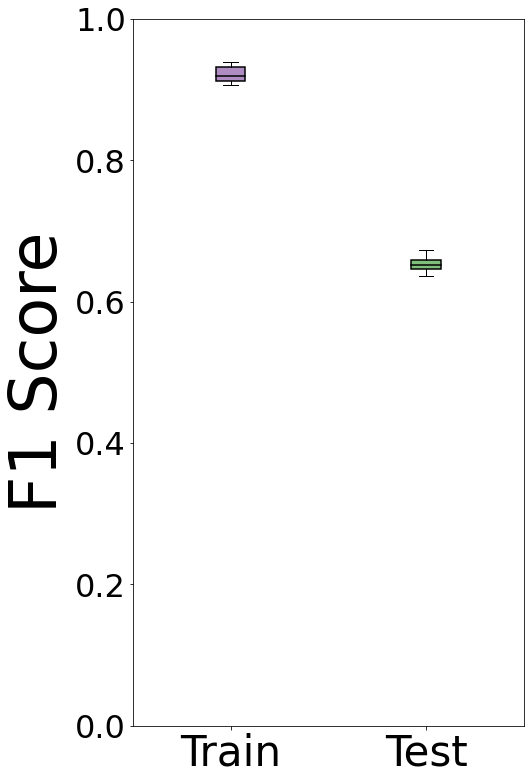

Train 0.9220830835251608 +/- 0.010597500522917937
Test 0.6536475389981156 +/- 0.010930571549463683
t_20 = 52.896 ,p= 0.0


In [19]:
data = [train_f1, test_f1]
labels = ['Train', 'Test']
boxplot(data, labels, y_lim=1, y_label='F1 Score', outputdir='/home/jiehyun.kim001/CACTAS/_EXPERIMENTS/')